In [1]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
import sqlalchemy as sql
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
import yfinance as yf

# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

In [2]:
df_BTCUSDT = yf.download("QQQ", interval="1d", start="2000-05-01", end=pd.to_datetime('today'))




[*********************100%***********************]  1 of 1 completed


In [3]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [4]:
### Oscillators ###
## RSI
df_BTCUSDT = appendData(df_BTCUSDT,ta.RSI(df_BTCUSDT))
## Sto-%K
df_BTCUSDT = appendData(df_BTCUSDT,ta.STOCH(df_BTCUSDT))
## CCI
df_BTCUSDT = appendData(df_BTCUSDT,ta.CCI(df_BTCUSDT))
## ADX
df_BTCUSDT = appendData(df_BTCUSDT,ta.ADX(df_BTCUSDT))
## DMI (Added to aid in interpreting ADX)
df_BTCUSDT = appendData(df_BTCUSDT,ta.DMI(df_BTCUSDT, 14))
## Awesome
df_BTCUSDT = appendData(df_BTCUSDT,ta.AO(df_BTCUSDT))
## Momentum
df_BTCUSDT = appendData(df_BTCUSDT,ta.MOM(df_BTCUSDT,10))
## MACD (We rename the undescriptive "SIGNAL" here)
## Sto-RSI
df_BTCUSDT = appendData(df_BTCUSDT,ta.STOCHRSI(df_BTCUSDT))
## Williams %R
df_BTCUSDT = appendData(df_BTCUSDT,ta.WILLIAMS(df_BTCUSDT))
## Bull-Bear Power
df_BTCUSDT = appendData(df_BTCUSDT,ta.EBBP(df_BTCUSDT))
## Ultimate (FinTA does not name this column, so we must)
df_BTCUSDT = appendData(df_BTCUSDT,ta.UO(df_BTCUSDT),["UO"])
### Moving Averages ###
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
## SMA, EMA
for i in sma_ema_averages:
    df_BTCUSDT = appendData(df_BTCUSDT,ta.SMA(df_BTCUSDT, i))
    df_BTCUSDT = appendData(df_BTCUSDT,ta.EMA(df_BTCUSDT, i))
## VWMA
df_BTCUSDT = appendData(df_BTCUSDT, ta.VAMA(df_BTCUSDT, 20))
## Hull
df_BTCUSDT = appendData(df_BTCUSDT,ta.HMA(df_BTCUSDT, 9))
# Ichimoku -- Base (Kijun) and Conversion (Tenkan) Only
df_BTCUSDT = appendData(df_BTCUSDT,ta.ICHIMOKU(df_BTCUSDT).drop(['senkou_span_a','SENKOU','CHIKOU'], axis=1))

In [5]:
database_connection_string = 'sqlite:///'
engine = sql.create_engine(database_connection_string, echo=True)
sql_statement = """
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )
"""
result = engine.execute(sql_statement)

2022-04-12 15:30:35,484 INFO sqlalchemy.engine.Engine 
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )

2022-04-12 15:30:35,493 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-12 15:30:35,495 INFO sqlalchemy.engine.Engine COMMIT


In [9]:
models_list = [KNeighborsClassifier(n_neighbors=3),SVC(), RandomForestClassifier()]
percent_threshold = .03
investment_amount = 10000
training_length = 60        


for m in models_list:
    model = m
    i = 3
    i_end = 5
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df_BTCUSDT[column_name] = df_BTCUSDT["Close"].pct_change(periods=i)
        
        # Initialize the new `Signal` column
        signal_column_name = str(m) + str(i) + "_signal"
        df_BTCUSDT[signal_column_name] = 0.0
        # Generate signal to buy stock long
        df_BTCUSDT.loc[(df_BTCUSDT[column_name] >= (percent_threshold)), signal_column_name] = 1
        # Drop all NaN values from the DataFrame
        df_BTCUSDT = df_BTCUSDT.dropna()
        y = df_BTCUSDT[signal_column_name]
        # set up X for ml 
        X = df_BTCUSDT[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)

        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Evaluate the model using a classification report
        training_report_train = classification_report(y_train, training_signal_predictions)
        #print(column_name)
        #print("Training Report")
        #print(training_report_train)

        # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)

        # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
        #training_report_test = classification_report(y_test, testing_signal_predictions)

        reportdf = pd.DataFrame(classification_report(y_test, testing_signal_predictions, output_dict=True)).transpose()
        
        engine.execute("INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)", (column_name, reportdf['precision'][0], reportdf['precision'][1], reportdf['recall'][0], reportdf['recall'][1], reportdf['f1-score'][0], reportdf['f1-score'][1],reportdf['support'][0], reportdf['support'][1], reportdf['precision'][2]))
       
       
        i+=1
    
sql_query = """
SELECT *
FROM crypto_outcome
"""
outcome = pd.read_sql_query(sql_query, engine, index_col='column_name')
outcome

2022-04-12 15:32:39,675 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-12 15:32:39,685 INFO sqlalchemy.engine.Engine [raw sql] ('KNeighborsClassifier(n_neighbors=3)3_period_return', 0.9358909641595154, 0.323943661971831, 0.987220447284345, 0.08303249097472924, 0.9608706918890905, 0.13218390804597702, 3756.0, 277.0, 0.9251177783287875)
2022-04-12 15:32:39,695 INFO sqlalchemy.engine.Engine COMMIT
2022-04-12 15:32:42,130 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-12 15:32:42,132 INFO sqlalchemy.engine.Engine [raw sql] ('KNeighborsClassifier(n_neighbors=3)4_period_return', 0.9155362170463271, 0.48360655737704916, 0.9826923076923076, 0.15167095115681234, 0.9479263283423878, 0.23091976516634047, 3640.0, 389.0, 0.9024571854058079)
2022-04-12 15:32:42,135 INFO sqlalchemy.engine.Engine COMMIT
2022-04-12 15:32:43,700 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?,

/Users/jacobburnett/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobburnett/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobburnett/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

2022-04-12 15:32:47,099 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-12 15:32:47,111 INFO sqlalchemy.engine.Engine [raw sql] ('SVC()4_period_return', 0.9089766155393513, 0.675, 0.9964167585446527, 0.06940874035989718, 0.95069033530572, 0.1258741258741259, 3628.0, 389.0, 0.9066467513069455)
2022-04-12 15:32:47,179 INFO sqlalchemy.engine.Engine COMMIT
2022-04-12 15:32:48,566 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-12 15:32:48,567 INFO sqlalchemy.engine.Engine [raw sql] ('SVC()5_period_return', 0.8839737108190091, 0.7857142857142857, 0.9965802222855514, 0.0874751491053678, 0.9369055592766242, 0.15742397137745975, 3509.0, 503.0, 0.8826021934197408)
2022-04-12 15:32:48,570 INFO sqlalchemy.engine.Engine COMMIT
2022-04-12 15:32:51,396 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-12 15:32:51,397 INFO sqlalchemy.engine.En

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
KNeighborsClassifier(n_neighbors=3)3_period_return,0.941470,0.625000,0.998864,0.029586,0.969318,0.056497,2641.0,169.0,0.940569
KNeighborsClassifier(n_neighbors=3)4_period_return,0.913510,0.571429,0.998828,0.016260,0.954265,0.031621,2559.0,246.0,0.912656
KNeighborsClassifier(n_neighbors=3)5_period_return,0.886225,0.666667,0.999193,0.012422,0.939325,0.024390,2479.0,322.0,0.885755
SVC()3_period_return,0.939557,0.000000,1.000000,0.000000,0.968836,0.000000,2627.0,169.0,0.939557
SVC()4_period_return,0.911954,0.000000,1.000000,0.000000,0.953950,0.000000,2548.0,246.0,0.911954
SVC()5_period_return,0.884546,0.000000,1.000000,0.000000,0.938737,0.000000,2467.0,322.0,0.884546
RandomForestClassifier()3_period_return,0.939677,1.000000,1.000000,0.005917,0.968900,0.011765,2617.0,169.0,0.939698
RandomForestClassifier()4_period_return,0.920799,0.392405,0.981073,0.126531,0.949981,0.191358,2536.0,245.0,0.905789
RandomForestClassifier()5_period_return,0.912066,0.400000,0.941392,0.300940,0.926497,0.343470,2457.0,319.0,0.867795


In [10]:
df_BTCUSDT.head()

,Open,High,Low,Close,Adj Close,Volume,14 period RSI,14 period STOCH %K,20 period CCI,14 period ADX.,DI+,DI-,AO,MOM,14 period stochastic RSI.,14 Williams %R,Bull.,Bear.,UO,5 period SMA,5 period EMA,10 period SMA,10 period EMA,20 period SMA,20 period EMA,30 period SMA,30 period EMA,50 period SMA,50 period EMA,100 period SMA,100 period EMA,200 period SMA,200 period EMA,20 period VAMA,9 period HMA.,TENKAN,KIJUN,KNeighborsClassifier(n_neighbors=3)3_period_return,KNeighborsClassifier(n_neighbors=3)3_signal,KNeighborsClassifier(n_neighbors=3)4_period_return,KNeighborsClassifier(n_neighbors=3)4_signal,KNeighborsClassifier(n_neighbors=3)5_period_return,KNeighborsClassifier(n_neighbors=3)5_signal,SVC()3_period_return,SVC()3_signal,SVC()4_period_return,SVC()4_signal,SVC()5_period_return,SVC()5_signal,RandomForestClassifier()3_period_return,RandomForestClassifier()3_signal,RandomForestClassifier()4_period_return,RandomForestClassifier()4_signal,RandomForestClassifier()5_period_return,RandomForestClassifier()5_signal,actual_return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-05-23,50.439999,50.450001,48.639999,48.650002,42.088112,65618000,55.901548,61.627926,107.228714,17.785482,27.154031,18.877079,4.124883,2.100002,0.650939,-38.372074,2.579941,0.769940,58.035036,49.308001,49.063700,47.498001,48.247623,47.210501,47.127727,46.210334,46.502750,43.6410,46.819305,50.480838,51.361763,65.956825,59.202553,47.539833,51.110556,47.650000,47.500,0.012698,0.0,0.015658,0.0,0.031813,1.0,0.012698,0.0,0.015658,0.0,0.031813,1.0,0.012698,0.0,0.015658,0.0,0.031813,1.0,-0.044204
2001-05-24,48.970001,49.990002,48.270000,49.900002,43.169540,61792500,58.900695,76.162806,101.932276,17.545336,25.214458,18.857736,3.984265,4.130001,0.651480,-23.837194,1.829950,0.109949,61.571713,49.708001,49.342467,47.911001,48.548056,47.508001,47.391753,46.507000,46.721927,43.7640,46.940119,50.396088,51.332686,65.735700,59.103322,47.837458,50.862446,47.650000,47.500,-0.022527,0.0,0.038718,1.0,0.041754,1.0,-0.022527,0.0,0.038718,1.0,0.041754,1.0,-0.022527,0.0,0.038718,1.0,0.041754,1.0,0.025694
2001-05-25,49.959999,50.020000,48.020000,48.990002,42.382263,36191100,55.919087,65.581415,74.843768,17.149884,23.413425,18.392900,3.867148,3.440002,0.651747,-34.418585,1.741385,-0.258615,57.626405,49.898001,49.224979,48.255001,48.628409,47.700001,47.543968,46.713334,46.868255,43.9008,47.020508,50.351613,51.286090,65.522525,58.995519,47.975109,50.091113,48.005001,47.500,-0.037525,0.0,-0.040353,0.0,0.019775,0.0,-0.037525,0.0,-0.040353,0.0,0.019775,0.0,-0.037525,0.0,-0.040353,0.0,0.019775,0.0,-0.018236
2001-05-29,48.500000,48.500000,46.099998,46.119999,39.899353,66609600,47.715315,32.209299,-36.999616,16.203664,21.741037,23.506982,3.133029,1.299999,0.643414,-67.790701,0.529758,-1.870244,49.799132,48.912001,48.189985,48.385001,48.172335,47.698500,47.408352,46.909000,46.819980,43.9992,46.985194,50.188438,51.183345,65.304063,58.858370,47.956367,48.548001,48.005001,47.525,-0.052004,0.0,-0.093910,0.0,-0.096572,0.0,-0.052004,0.0,-0.093910,0.0,-0.096572,0.0,-0.052004,0.0,-0.093910,0.0,-0.096572,0.0,-0.058583
2001-05-30,45.430000,45.849998,44.080002,44.430000,38.437325,81397400,43.654003,12.558157,-131.040058,16.269040,20.188106,28.527735,1.741118,-0.720001,0.635388,-87.441843,-1.614495,-3.384491,46.078863,47.618001,46.936657,48.313001,47.491910,47.517500,47.124699,47.015000,46.665788,44.0226,46.884988,50.019613,51.049045,65.070900,58.704788,47.722312,46.444000,48.015001,47.525,-0.109619,0.0,-0.086742,0.0,-0.127112,0.0,-0.109619,0.0,-0.086742,0.0,-0.127112,0.0,-0.109619,0.0,-0.086742,0.0,-0.127112,0.0,-0.036644


In [11]:
period = -3
#Create a new empty predictions DataFrame using code provided below.
#Use the pct_change function to generate the returns from "close"
df_BTCUSDT["actual_return"] = df_BTCUSDT["Close"].pct_change()
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["signal"] = df_BTCUSDT["RandomForestClassifier()3_signal"]

outer_counter = 0
for index, row in predictions_df.iterrows():
    if predictions_df.at[index, "signal"] == 1.0 and outer_counter ==0:
        predictions_df.at[index, "signal_2"] = predictions_df.at[index, "signal"]
        outer_counter = outer_counter + 1
    elif outer_counter > 0 and outer_counter < (period * -1):
        predictions_df.at[index, "signal_2"] = 0
        outer_counter = outer_counter + 1
    elif outer_counter == (period * -1):
        outer_counter = 0

predictions_df["signal_2"].fillna(0,inplace=True)
predictions_df["29_period_return"] = df_BTCUSDT["Close"].pct_change(periods=period)
# # intial_investment = 10000
# # # Add in actual returns and calculate trading returns
predictions_df['actual_return'] = df_BTCUSDT['actual_return']
predictions_df['algo_RFC_29'] = predictions_df.loc[predictions_df["signal_2"]==1]["29_period_return"]
predictions_df["algo_RFC_29"].fillna(0,inplace=True)
# # #predictions_df['trading_algorithm_returns_3'] = predictions_df.loc[predictions_df["signal"]==1]["3_period_return"]
# # predictions_df["algo_RFC_29"].fillna(0, inplace=True)
# # #predictions_df["algo_RFC_29_cumulative"] = 
# # #predictions_df["algo_RFC_29_cumulative"] = #predictions_df["algo_RFC_29"] + predictions_df["algo_RFC_29"].shift(1) + 1
# # #(1 + predictions_df["algo_RFC_29"]).cumprod() - 1
predictions_df["algo_cumulative_returns"] = (1 + predictions_df["algo_RFC_29"]).cumprod() - 1
predictions_df["actual_cumulative_returns"] = (1 + predictions_df["actual_return"]).cumprod() - 1
predictions_df.dropna()
predictions_df.tail()

,signal,signal_2,29_period_return,actual_return,algo_RFC_29,algo_cumulative_returns,actual_cumulative_returns
Date,,,,,,,
2022-04-06,0.0,0.0,0.036287,-0.021711,0.0,-0.247763,8.154185
2022-04-07,0.0,0.0,0.043158,0.002378,0.0,-0.247763,8.175952
2022-04-08,0.0,0.0,NaN,-0.013979,0.0,-0.247763,8.047681
2022-04-11,0.0,0.0,NaN,-0.023657,0.0,-0.247763,7.833636
2022-04-12,0.0,0.0,NaN,-0.004224,0.0,-0.247763,7.796321


<AxesSubplot:xlabel='Date'>

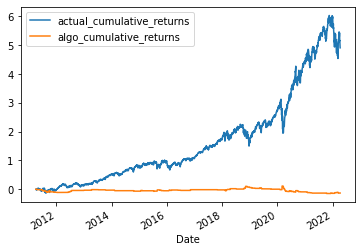

In [8]:
predictions_df[["actual_cumulative_returns","algo_cumulative_returns"]].plot()